# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 4202496/11490434 [=========>....................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 10:51 - loss: 0.6936

  34/1875 [..............................] - ETA: 2s - loss: 0.5313   

  65/1875 [>.............................] - ETA: 2s - loss: 0.4568

 101/1875 [>.............................] - ETA: 2s - loss: 0.4120

 138/1875 [=>............................] - ETA: 2s - loss: 0.3834

 175/1875 [=>............................] - ETA: 2s - loss: 0.3630

 207/1875 [==>...........................] - ETA: 2s - loss: 0.3491

 247/1875 [==>...........................] - ETA: 2s - loss: 0.3350

 277/1875 [===>..........................] - ETA: 2s - loss: 0.3261

 313/1875 [====>.........................] - ETA: 2s - loss: 0.3167

 351/1875 [====>.........................] - ETA: 2s - loss: 0.3081

 387/1875 [=====>........................] - ETA: 2s - loss: 0.3009

 421/1875 [=====>........................] - ETA: 2s - loss: 0.2948

 456/1875 [======>.......................] - ETA: 2s - loss: 0.2891

 487/1875 [======>.......................] - ETA: 2s - loss: 0.2845

 522/1875 [=======>......................] - ETA: 1s - loss: 0.2797

 557/1875 [=======>......................] - ETA: 1s - loss: 0.2752

 594/1875 [========>.....................] - ETA: 1s - loss: 0.2709

 630/1875 [=========>....................] - ETA: 1s - loss: 0.2670

 666/1875 [=========>....................] - ETA: 1s - loss: 0.2633

 703/1875 [==========>...................] - ETA: 1s - loss: 0.2597

 738/1875 [==========>...................] - ETA: 1s - loss: 0.2566

 771/1875 [===========>..................] - ETA: 1s - loss: 0.2538

 807/1875 [===========>..................] - ETA: 1s - loss: 0.2509

 840/1875 [============>.................] - ETA: 1s - loss: 0.2483

 877/1875 [=============>................] - ETA: 1s - loss: 0.2456

 912/1875 [=============>................] - ETA: 1s - loss: 0.2432

 944/1875 [==============>...............] - ETA: 1s - loss: 0.2411

 985/1875 [==============>...............] - ETA: 1s - loss: 0.2385

1020/1875 [===============>..............] - ETA: 1s - loss: 0.2363

1057/1875 [===============>..............] - ETA: 1s - loss: 0.2342

1092/1875 [================>.............] - ETA: 1s - loss: 0.2322

1130/1875 [=================>............] - ETA: 1s - loss: 0.2302

1162/1875 [=================>............] - ETA: 1s - loss: 0.2285

1203/1875 [==================>...........] - ETA: 0s - loss: 0.2265

1246/1875 [==================>...........] - ETA: 0s - loss: 0.2244

1289/1875 [===================>..........] - ETA: 0s - loss: 0.2225

1325/1875 [====================>.........] - ETA: 0s - loss: 0.2209

1371/1875 [====================>.........] - ETA: 0s - loss: 0.2190

1411/1875 [=====================>........] - ETA: 0s - loss: 0.2173

1449/1875 [======================>.......] - ETA: 0s - loss: 0.2158

1482/1875 [======================>.......] - ETA: 0s - loss: 0.2146

1519/1875 [=======================>......] - ETA: 0s - loss: 0.2132

1557/1875 [=======================>......] - ETA: 0s - loss: 0.2118

1594/1875 [========================>.....] - ETA: 0s - loss: 0.2105

1619/1875 [========================>.....] - ETA: 0s - loss: 0.2097

1655/1875 [=========================>....] - ETA: 0s - loss: 0.2085

1691/1875 [==========================>...] - ETA: 0s - loss: 0.2073

1729/1875 [==========================>...] - ETA: 0s - loss: 0.2061

1766/1875 [===========================>..] - ETA: 0s - loss: 0.2050

1806/1875 [===========================>..] - ETA: 0s - loss: 0.2038



1843/1875 [============================>.] - ETA: 0s - loss: 0.2027

1875/1875 [==============================] - 3s 1ms/step - loss: 0.2018


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1096

  42/1875 [..............................] - ETA: 2s - loss: 0.1096

  81/1875 [>.............................] - ETA: 2s - loss: 0.1094

 112/1875 [>.............................] - ETA: 2s - loss: 0.1093

 142/1875 [=>............................] - ETA: 2s - loss: 0.1091

 175/1875 [=>............................] - ETA: 2s - loss: 0.1090

 208/1875 [==>...........................] - ETA: 2s - loss: 0.1089

 244/1875 [==>...........................] - ETA: 2s - loss: 0.1088

 275/1875 [===>..........................] - ETA: 2s - loss: 0.1087

 317/1875 [====>.........................] - ETA: 2s - loss: 0.1086

 356/1875 [====>.........................] - ETA: 2s - loss: 0.1085

 398/1875 [=====>........................] - ETA: 2s - loss: 0.1083

 437/1875 [=====>........................] - ETA: 2s - loss: 0.1082

 473/1875 [======>.......................] - ETA: 1s - loss: 0.1081

 512/1875 [=======>......................] - ETA: 1s - loss: 0.1079

 549/1875 [=======>......................] - ETA: 1s - loss: 0.1078

 587/1875 [========>.....................] - ETA: 1s - loss: 0.1077

 622/1875 [========>.....................] - ETA: 1s - loss: 0.1076

 661/1875 [=========>....................] - ETA: 1s - loss: 0.1075

 696/1875 [==========>...................] - ETA: 1s - loss: 0.1074

 734/1875 [==========>...................] - ETA: 1s - loss: 0.1073

 771/1875 [===========>..................] - ETA: 1s - loss: 0.1072

 807/1875 [===========>..................] - ETA: 1s - loss: 0.1071

 835/1875 [============>.................] - ETA: 1s - loss: 0.1071

 872/1875 [============>.................] - ETA: 1s - loss: 0.1070

 905/1875 [=============>................] - ETA: 1s - loss: 0.1069

 940/1875 [==============>...............] - ETA: 1s - loss: 0.1068

 976/1875 [==============>...............] - ETA: 1s - loss: 0.1067

1011/1875 [===============>..............] - ETA: 1s - loss: 0.1067

1046/1875 [===============>..............] - ETA: 1s - loss: 0.1066

1081/1875 [================>.............] - ETA: 1s - loss: 0.1065

1116/1875 [================>.............] - ETA: 1s - loss: 0.1065

1147/1875 [=================>............] - ETA: 1s - loss: 0.1064

1182/1875 [=================>............] - ETA: 0s - loss: 0.1063

1219/1875 [==================>...........] - ETA: 0s - loss: 0.1063

1255/1875 [===================>..........] - ETA: 0s - loss: 0.1062

1289/1875 [===================>..........] - ETA: 0s - loss: 0.1061

1324/1875 [====================>.........] - ETA: 0s - loss: 0.1061

1361/1875 [====================>.........] - ETA: 0s - loss: 0.1060

1398/1875 [=====================>........] - ETA: 0s - loss: 0.1059

1436/1875 [=====================>........] - ETA: 0s - loss: 0.1059

1474/1875 [======================>.......] - ETA: 0s - loss: 0.1058

1512/1875 [=======================>......] - ETA: 0s - loss: 0.1057

1549/1875 [=======================>......] - ETA: 0s - loss: 0.1057

1587/1875 [========================>.....] - ETA: 0s - loss: 0.1056

1623/1875 [========================>.....] - ETA: 0s - loss: 0.1055

1660/1875 [=========================>....] - ETA: 0s - loss: 0.1055

1698/1875 [==========================>...] - ETA: 0s - loss: 0.1054

1736/1875 [==========================>...] - ETA: 0s - loss: 0.1054

1773/1875 [===========================>..] - ETA: 0s - loss: 0.1053

1811/1875 [===========================>..] - ETA: 0s - loss: 0.1053

1849/1875 [============================>.] - ETA: 0s - loss: 0.1052

1875/1875 [==============================] - 3s 1ms/step - loss: 0.1052


Epoch 3/5
   1/1875 [..............................] - ETA: 2s - loss: 0.0860

  39/1875 [..............................] - ETA: 2s - loss: 0.0965

  76/1875 [>.............................] - ETA: 2s - loss: 0.0970

 117/1875 [>.............................] - ETA: 2s - loss: 0.0974

 151/1875 [=>............................] - ETA: 2s - loss: 0.0976

 191/1875 [==>...........................] - ETA: 2s - loss: 0.0977

 234/1875 [==>...........................] - ETA: 2s - loss: 0.0979

 275/1875 [===>..........................] - ETA: 2s - loss: 0.0980

 313/1875 [====>.........................] - ETA: 2s - loss: 0.0980

 351/1875 [====>.........................] - ETA: 1s - loss: 0.0981

 389/1875 [=====>........................] - ETA: 1s - loss: 0.0981

 418/1875 [=====>........................] - ETA: 1s - loss: 0.0981

 457/1875 [======>.......................] - ETA: 1s - loss: 0.0982

 485/1875 [======>.......................] - ETA: 1s - loss: 0.0982

 511/1875 [=======>......................] - ETA: 1s - loss: 0.0982

 541/1875 [=======>......................] - ETA: 1s - loss: 0.0982

 573/1875 [========>.....................] - ETA: 1s - loss: 0.0982

 601/1875 [========>.....................] - ETA: 1s - loss: 0.0982

 630/1875 [=========>....................] - ETA: 1s - loss: 0.0982

 664/1875 [=========>....................] - ETA: 1s - loss: 0.0982

 694/1875 [==========>...................] - ETA: 1s - loss: 0.0982

 725/1875 [==========>...................] - ETA: 1s - loss: 0.0982

 752/1875 [===========>..................] - ETA: 1s - loss: 0.0982

 784/1875 [===========>..................] - ETA: 1s - loss: 0.0982

 815/1875 [============>.................] - ETA: 1s - loss: 0.0982

 841/1875 [============>.................] - ETA: 1s - loss: 0.0982

 878/1875 [=============>................] - ETA: 1s - loss: 0.0982

 915/1875 [=============>................] - ETA: 1s - loss: 0.0982

 951/1875 [==============>...............] - ETA: 1s - loss: 0.0981

 983/1875 [==============>...............] - ETA: 1s - loss: 0.0981

1011/1875 [===============>..............] - ETA: 1s - loss: 0.0981

1045/1875 [===============>..............] - ETA: 1s - loss: 0.0981

1083/1875 [================>.............] - ETA: 1s - loss: 0.0981

1117/1875 [================>.............] - ETA: 1s - loss: 0.0981

1149/1875 [=================>............] - ETA: 1s - loss: 0.0981

1182/1875 [=================>............] - ETA: 1s - loss: 0.0981

1213/1875 [==================>...........] - ETA: 1s - loss: 0.0981

1245/1875 [==================>...........] - ETA: 0s - loss: 0.0981

1279/1875 [===================>..........] - ETA: 0s - loss: 0.0980

1310/1875 [===================>..........] - ETA: 0s - loss: 0.0980

1343/1875 [====================>.........] - ETA: 0s - loss: 0.0980

1375/1875 [=====================>........] - ETA: 0s - loss: 0.0980

1408/1875 [=====================>........] - ETA: 0s - loss: 0.0980

1435/1875 [=====================>........] - ETA: 0s - loss: 0.0980

1469/1875 [======================>.......] - ETA: 0s - loss: 0.0980

1498/1875 [======================>.......] - ETA: 0s - loss: 0.0980

1530/1875 [=======================>......] - ETA: 0s - loss: 0.0979

1558/1875 [=======================>......] - ETA: 0s - loss: 0.0979

1589/1875 [========================>.....] - ETA: 0s - loss: 0.0979

1620/1875 [========================>.....] - ETA: 0s - loss: 0.0979

1647/1875 [=========================>....] - ETA: 0s - loss: 0.0979

1679/1875 [=========================>....] - ETA: 0s - loss: 0.0979

1710/1875 [==========================>...] - ETA: 0s - loss: 0.0979

1742/1875 [==========================>...] - ETA: 0s - loss: 0.0979

1775/1875 [===========================>..] - ETA: 0s - loss: 0.0978

1801/1875 [===========================>..] - ETA: 0s - loss: 0.0978

1834/1875 [============================>.] - ETA: 0s - loss: 0.0978

1862/1875 [============================>.] - ETA: 0s - loss: 0.0978

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0978


Epoch 4/5
   1/1875 [..............................] - ETA: 5s - loss: 0.0947

  35/1875 [..............................] - ETA: 2s - loss: 0.0955

  63/1875 [>.............................] - ETA: 2s - loss: 0.0956

  93/1875 [>.............................] - ETA: 2s - loss: 0.0957

 124/1875 [>.............................] - ETA: 2s - loss: 0.0956

 152/1875 [=>............................] - ETA: 2s - loss: 0.0957

 187/1875 [=>............................] - ETA: 2s - loss: 0.0958

 212/1875 [==>...........................] - ETA: 2s - loss: 0.0958

 243/1875 [==>...........................] - ETA: 2s - loss: 0.0958

 276/1875 [===>..........................] - ETA: 2s - loss: 0.0958

 305/1875 [===>..........................] - ETA: 2s - loss: 0.0958

 337/1875 [====>.........................] - ETA: 2s - loss: 0.0958

 369/1875 [====>.........................] - ETA: 2s - loss: 0.0958

 399/1875 [=====>........................] - ETA: 2s - loss: 0.0958

 427/1875 [=====>........................] - ETA: 2s - loss: 0.0958

 459/1875 [======>.......................] - ETA: 2s - loss: 0.0958

 489/1875 [======>.......................] - ETA: 2s - loss: 0.0958

 520/1875 [=======>......................] - ETA: 2s - loss: 0.0958

 552/1875 [=======>......................] - ETA: 2s - loss: 0.0958

 584/1875 [========>.....................] - ETA: 2s - loss: 0.0958

 612/1875 [========>.....................] - ETA: 2s - loss: 0.0958

 644/1875 [=========>....................] - ETA: 2s - loss: 0.0958

 677/1875 [=========>....................] - ETA: 1s - loss: 0.0958

 709/1875 [==========>...................] - ETA: 1s - loss: 0.0958

 741/1875 [==========>...................] - ETA: 1s - loss: 0.0958

 774/1875 [===========>..................] - ETA: 1s - loss: 0.0958

 805/1875 [===========>..................] - ETA: 1s - loss: 0.0958

 838/1875 [============>.................] - ETA: 1s - loss: 0.0958

 872/1875 [============>.................] - ETA: 1s - loss: 0.0958

 903/1875 [=============>................] - ETA: 1s - loss: 0.0958

 936/1875 [=============>................] - ETA: 1s - loss: 0.0958

 969/1875 [==============>...............] - ETA: 1s - loss: 0.0958

1002/1875 [===============>..............] - ETA: 1s - loss: 0.0958

1035/1875 [===============>..............] - ETA: 1s - loss: 0.0958

1066/1875 [================>.............] - ETA: 1s - loss: 0.0958

1095/1875 [================>.............] - ETA: 1s - loss: 0.0958

1126/1875 [=================>............] - ETA: 1s - loss: 0.0958

1159/1875 [=================>............] - ETA: 1s - loss: 0.0958

1189/1875 [==================>...........] - ETA: 1s - loss: 0.0958

1222/1875 [==================>...........] - ETA: 1s - loss: 0.0958

1261/1875 [===================>..........] - ETA: 0s - loss: 0.0958

1300/1875 [===================>..........] - ETA: 0s - loss: 0.0958

1339/1875 [====================>.........] - ETA: 0s - loss: 0.0958

1378/1875 [=====================>........] - ETA: 0s - loss: 0.0958

1417/1875 [=====================>........] - ETA: 0s - loss: 0.0958

1444/1875 [======================>.......] - ETA: 0s - loss: 0.0958

1471/1875 [======================>.......] - ETA: 0s - loss: 0.0958

1501/1875 [=======================>......] - ETA: 0s - loss: 0.0958

1533/1875 [=======================>......] - ETA: 0s - loss: 0.0958

1559/1875 [=======================>......] - ETA: 0s - loss: 0.0958

1589/1875 [========================>.....] - ETA: 0s - loss: 0.0958

1620/1875 [========================>.....] - ETA: 0s - loss: 0.0958

1653/1875 [=========================>....] - ETA: 0s - loss: 0.0958

1680/1875 [=========================>....] - ETA: 0s - loss: 0.0958

1709/1875 [==========================>...] - ETA: 0s - loss: 0.0958

1737/1875 [==========================>...] - ETA: 0s - loss: 0.0958

1769/1875 [===========================>..] - ETA: 0s - loss: 0.0958

1805/1875 [===========================>..] - ETA: 0s - loss: 0.0958

1835/1875 [============================>.] - ETA: 0s - loss: 0.0958

1870/1875 [============================>.] - ETA: 0s - loss: 0.0958

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0958


Epoch 5/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1056

  35/1875 [..............................] - ETA: 3s - loss: 0.0955

  66/1875 [>.............................] - ETA: 2s - loss: 0.0955

 102/1875 [>.............................] - ETA: 2s - loss: 0.0955

 133/1875 [=>............................] - ETA: 2s - loss: 0.0955

 162/1875 [=>............................] - ETA: 2s - loss: 0.0955

 190/1875 [==>...........................] - ETA: 2s - loss: 0.0955

 221/1875 [==>...........................] - ETA: 2s - loss: 0.0954

 250/1875 [===>..........................] - ETA: 2s - loss: 0.0954

 283/1875 [===>..........................] - ETA: 2s - loss: 0.0954

 314/1875 [====>.........................] - ETA: 2s - loss: 0.0954

 344/1875 [====>.........................] - ETA: 2s - loss: 0.0954

 376/1875 [=====>........................] - ETA: 2s - loss: 0.0954

 407/1875 [=====>........................] - ETA: 2s - loss: 0.0954

 441/1875 [======>.......................] - ETA: 2s - loss: 0.0954

 469/1875 [======>.......................] - ETA: 2s - loss: 0.0954

 500/1875 [=======>......................] - ETA: 2s - loss: 0.0954

 531/1875 [=======>......................] - ETA: 2s - loss: 0.0953

 562/1875 [=======>......................] - ETA: 2s - loss: 0.0953

 596/1875 [========>.....................] - ETA: 2s - loss: 0.0953

 626/1875 [=========>....................] - ETA: 2s - loss: 0.0953

 657/1875 [=========>....................] - ETA: 2s - loss: 0.0953

 687/1875 [=========>....................] - ETA: 1s - loss: 0.0953

 721/1875 [==========>...................] - ETA: 1s - loss: 0.0953

 754/1875 [===========>..................] - ETA: 1s - loss: 0.0953

 784/1875 [===========>..................] - ETA: 1s - loss: 0.0953

 819/1875 [============>.................] - ETA: 1s - loss: 0.0953

 852/1875 [============>.................] - ETA: 1s - loss: 0.0953

 885/1875 [=============>................] - ETA: 1s - loss: 0.0953

 912/1875 [=============>................] - ETA: 1s - loss: 0.0953

 941/1875 [==============>...............] - ETA: 1s - loss: 0.0953

 977/1875 [==============>...............] - ETA: 1s - loss: 0.0953

1009/1875 [===============>..............] - ETA: 1s - loss: 0.0953

1046/1875 [===============>..............] - ETA: 1s - loss: 0.0953

1080/1875 [================>.............] - ETA: 1s - loss: 0.0953

1117/1875 [================>.............] - ETA: 1s - loss: 0.0953

1153/1875 [=================>............] - ETA: 1s - loss: 0.0953

1191/1875 [==================>...........] - ETA: 1s - loss: 0.0953

1229/1875 [==================>...........] - ETA: 1s - loss: 0.0953

1263/1875 [===================>..........] - ETA: 0s - loss: 0.0952

1296/1875 [===================>..........] - ETA: 0s - loss: 0.0952

1328/1875 [====================>.........] - ETA: 0s - loss: 0.0952

1362/1875 [====================>.........] - ETA: 0s - loss: 0.0952

1393/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1426/1875 [=====================>........] - ETA: 0s - loss: 0.0952

1459/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1491/1875 [======================>.......] - ETA: 0s - loss: 0.0952

1521/1875 [=======================>......] - ETA: 0s - loss: 0.0952

1553/1875 [=======================>......] - ETA: 0s - loss: 0.0952

1584/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1612/1875 [========================>.....] - ETA: 0s - loss: 0.0952

1647/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1685/1875 [=========================>....] - ETA: 0s - loss: 0.0952

1724/1875 [==========================>...] - ETA: 0s - loss: 0.0952

1763/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1802/1875 [===========================>..] - ETA: 0s - loss: 0.0952

1840/1875 [============================>.] - ETA: 0s - loss: 0.0952

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0952


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

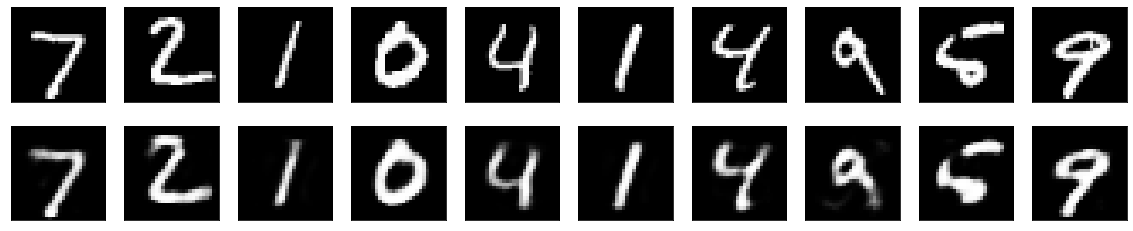

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
